Two-stage Marketing Mix Modeling notebook (Python)
Skelet

Sections:
1. Setup & Imports
2. Load data & initial EDA
3. Data preparation (flags, seasonality, adstock, lags)
4. Feature engineering
5. Stage 1: Google spend model (Ridge)
6. Stage 2: Revenue model (ElasticNet + XGBoost check)
7. Time-series CV (rolling) for both stages
8. Diagnostics (residuals, VIF, ACF, coef stability)
9. Sensitivity simulations (price/promo/budget)
10. Attribution (direct / indirect effects with bootstrap)
11. Save results & write-up snippets


In [4]:
"Importing the file "
path='./data/Assessment 2 - MMM Weekly.csv'

In [5]:
# 1) Setup & Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,accuracy_score, precision_score, recall_score, f1_score, classification_report
import statsmodels.api as sm
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
# 2) Load data & initial EDA
# Adjust path as needed
df = pd.read_csv(path, parse_dates=['week'])
df = df.sort_values('week').reset_index(drop=True)

In [7]:
# Quick peek
print(df.shape)
df.head(20)

(104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95
5,2023-10-22,4195.29,3385.89,0.00,3438.69,0.00,0,102.55,0,116640,25808,141742.69
6,2023-10-29,4788.44,4012.79,0.00,3103.79,838.75,0,107.29,0,109633,15211,42968.41
7,2023-11-05,6862.08,0.00,0.00,2852.10,2230.06,0,110.24,0,135573,13775,1.00
8,2023-11-12,5792.88,0.00,0.00,3003.76,1598.50,0,108.45,0,114713,22805,23117.23
9,2023-11-19,5881.88,0.00,2735.20,3705.38,2952.89,0,108.59,0,146399,21043,26904.34


In [8]:
# Basic missing / value checks
print(df.isna().sum())
print(df.describe())


week                0
facebook_spend      0
google_spend        0
tiktok_spend        0
instagram_spend     0
snapchat_spend      0
social_followers    0
average_price       0
promotions          0
emails_send         0
sms_send            0
revenue             0
dtype: int64
                      week  facebook_spend  google_spend  tiktok_spend  \
count                  104      104.000000    104.000000    104.000000   
mean   2024-09-11 12:00:00     5346.302500   1543.866442    955.632212   
min    2023-09-17 00:00:00     2456.940000      0.000000      0.000000   
25%    2024-03-15 06:00:00     4538.977500      0.000000      0.000000   
50%    2024-09-11 12:00:00     5293.780000      0.000000      0.000000   
75%    2025-03-10 18:00:00     6033.325000   3374.205000   2487.172500   
max    2025-09-07 00:00:00     9325.180000   6083.160000   4143.250000   
std                    NaN     1168.961177   1863.350279   1376.993132   

       instagram_spend  snapchat_spend  social_followers

In [9]:
# Find where revenue == 1
mask = df['revenue'] == 1

# Replace with mean of previous and next row values
df.loc[mask, 'revenue'] = (
    df['revenue'].shift(2) + df['revenue'].shift(-2)
) / 2

# Handle edge cases if 1 is in the first or last row
df['revenue'] = df['revenue'].fillna(method='bfill').fillna(method='ffill')


In [10]:
df.head(60)

,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.160
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.020
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.010
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.780
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.950
5,2023-10-22,4195.29,3385.89,0.00,3438.69,0.00,0,102.55,0,116640,25808,141742.690
6,2023-10-29,4788.44,4012.79,0.00,3103.79,838.75,0,107.29,0,109633,15211,42968.410
7,2023-11-05,6862.08,0.00,0.00,2852.10,2230.06,0,110.24,0,135573,13775,84323.515
8,2023-11-12,5792.88,0.00,0.00,3003.76,1598.50,0,108.45,0,114713,22805,23117.230
9,2023-11-19,5881.88,0.00,2735.20,3705.38,2952.89,0,108.59,0,146399,21043,26904.340


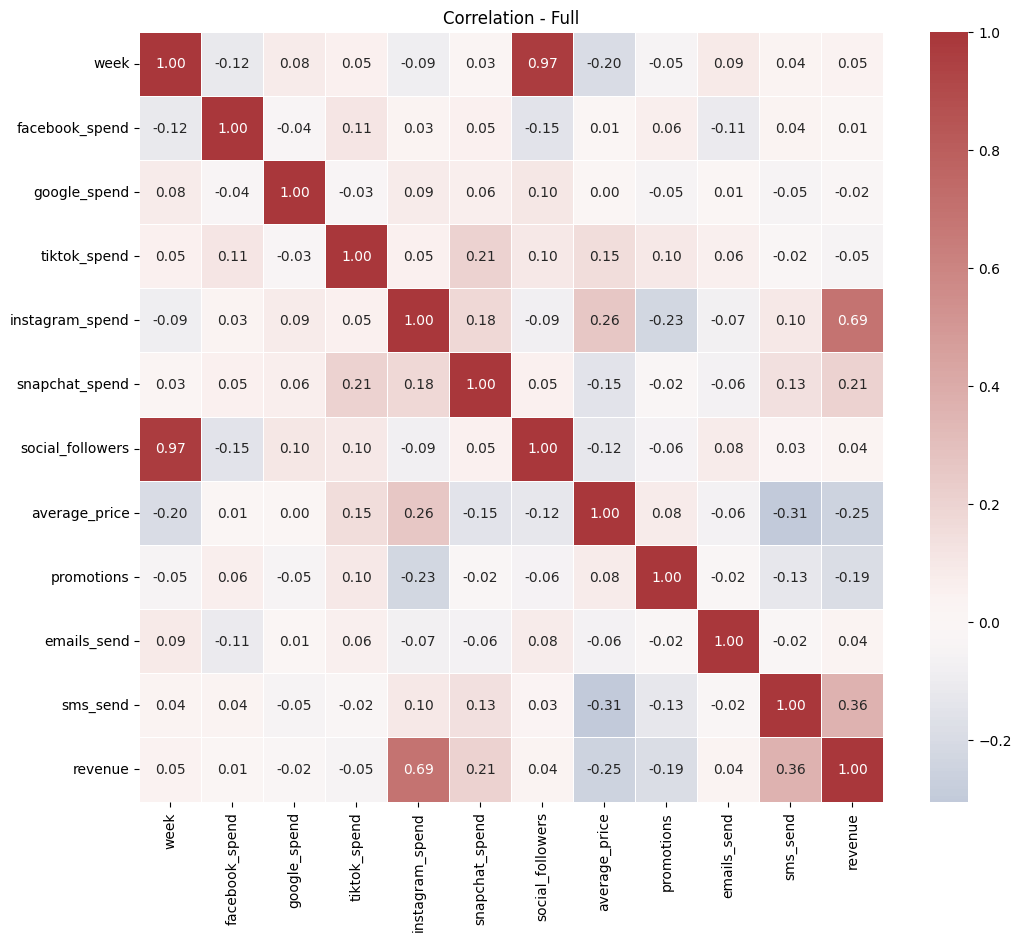

In [11]:
# Correlation heatmap (full)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='vlag', center=0, linewidths=0.5)
plt.title('Correlation - Full')
plt.show()

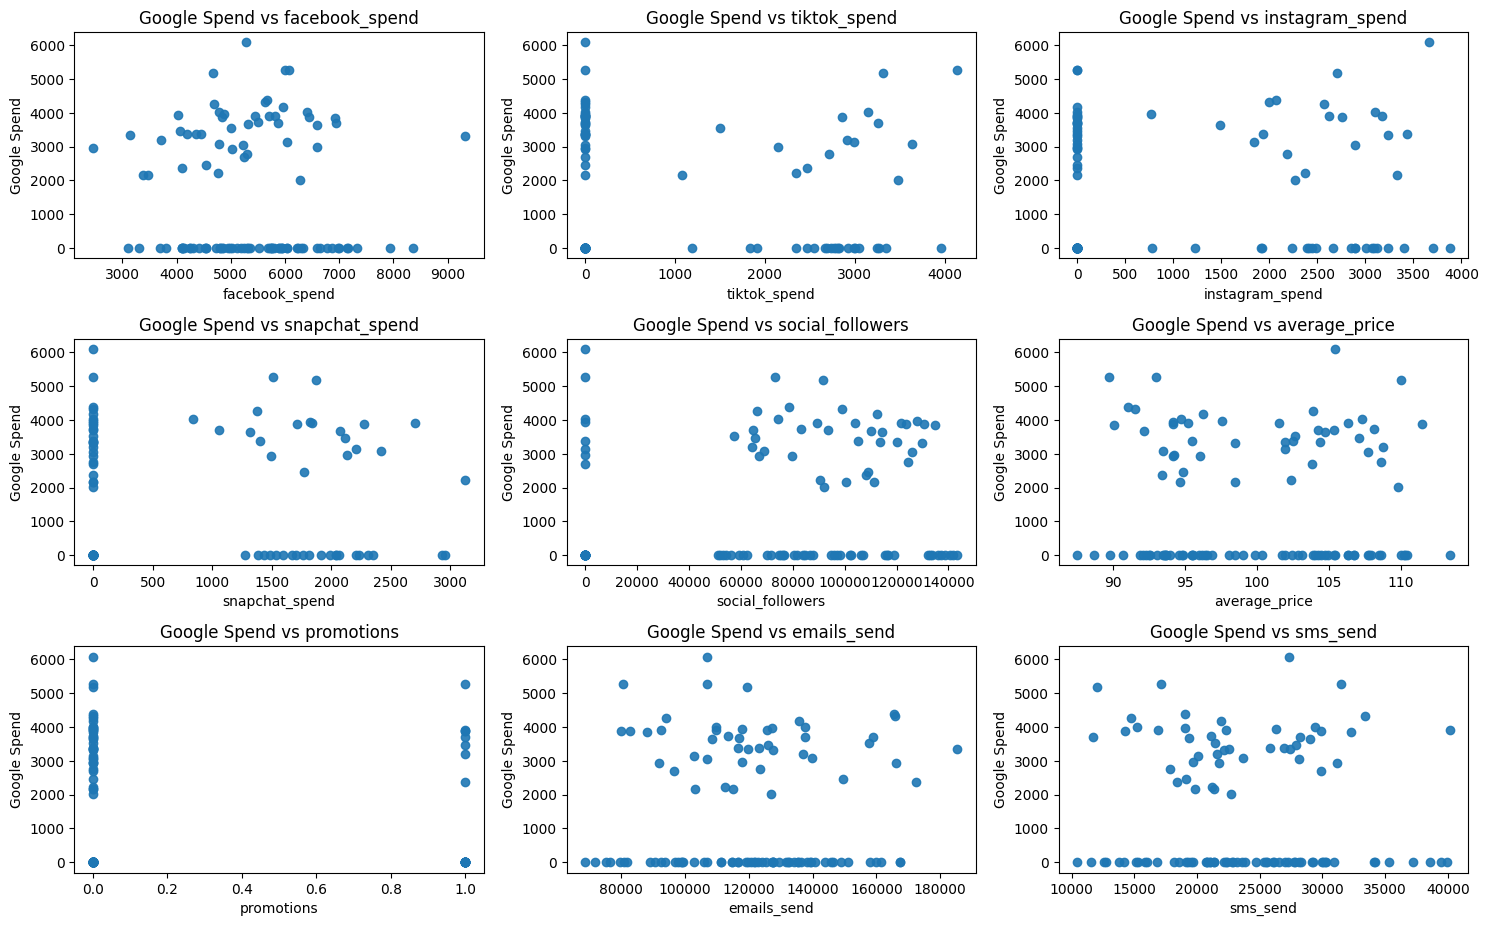

In [12]:
import matplotlib.pyplot as plt

features = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend',
            'social_followers','average_price','promotions','emails_send','sms_send']

plt.figure(figsize=(15,12))
for i, col in enumerate(features):
    plt.subplot(4, 3, i+1)
    plt.scatter(df[col], df['google_spend'], alpha=0.9)
    plt.xlabel(col)
    plt.ylabel('Google Spend')
    plt.title(f'Google Spend vs {col}')
plt.tight_layout()
plt.show()


Google Spend is NOT directly related to revenue, but depends on total spend → supports treating it as a mediator variable.

Instagram Spend is the clearest revenue driver → strongest actionable lever.

Average Price strongly influences revenue negatively → price sensitivity is a real factor.

Promotions don’t always work → might cannibalize baseline sales.

Followers growth does not directly translate into revenue in this dataset.

So, the heatmap confirms the causal design:

Social (FB, TikTok, Snap) → influence Google (mediator)

Google + Instagram + Price + Promotions → affect Revenue

In [13]:
# 3) Data preparation
# Flags and basic derived vars
df['total_spends'] = df[['facebook_spend','google_spend','tiktok_spend','instagram_spend','snapchat_spend']].sum(axis=1)
df['followers_diff'] = df['social_followers'].diff().fillna(0)
df['zero_spend'] = (df['total_spends'] == 0).astype(int)


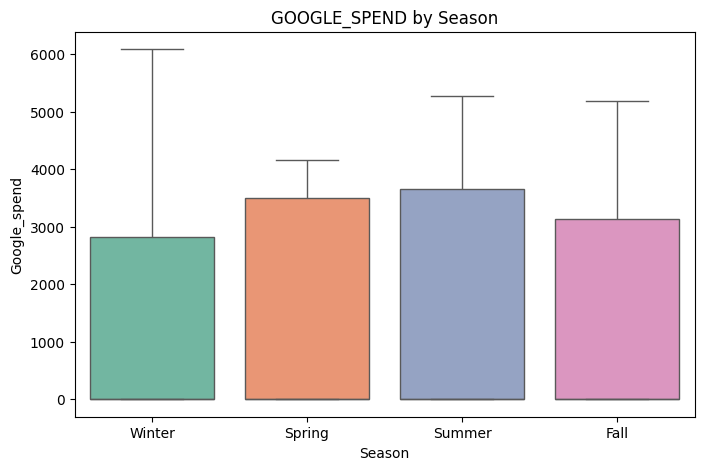

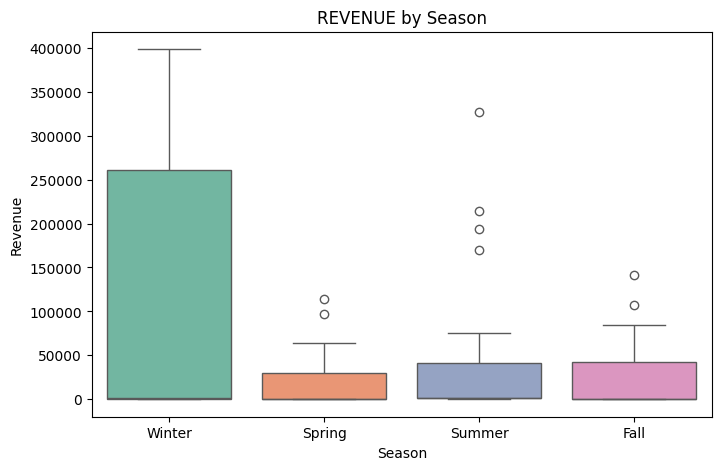

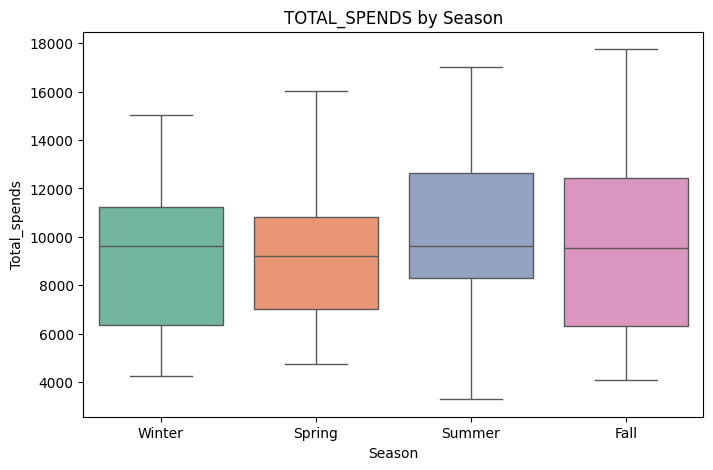

Index(['week', 'facebook_spend', 'google_spend', 'tiktok_spend',
       'instagram_spend', 'snapchat_spend', 'social_followers',
       'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue',
       'total_spends', 'followers_diff', 'zero_spend', 'month', 'season'],
      dtype='object')


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

#  First create seasonality/time features
df['month'] = df['week'].dt.month

def get_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

#  Now define features for plotting
spend_features = ['google_spend', 'revenue', 'total_spends']

# Create boxplots by season
for feature in spend_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        x='season',
        y=feature,
        data=df,
        order=['Winter', 'Spring', 'Summer', 'Fall'],
        palette='Set2',
        showfliers=True
    )
    plt.title(f'{feature.upper()} by Season')
    plt.xlabel("Season")
    plt.ylabel(feature.capitalize())
    plt.show()

print(df.columns)


In [15]:
# 4) Feature engineering
# Adstock function
def adstock(series, decay=0.5):
    s = series.fillna(0).astype(float).copy()
    out = s.copy()
    for i in range(1, len(s)):
        out.iloc[i] = s.iloc[i] + decay * out.iloc[i-1]
    return out

spend_cols = ['facebook_spend','google_spend','tiktok_spend','instagram_spend','snapchat_spend']
for col in spend_cols:
    df[f'{col}_ad'] = adstock(df[col], decay=0.5)

# Lags (1..4)
lags = [1,2,3,4]
for lag in lags:
    df[f'instagram_lag_{lag}'] = df['instagram_spend'].shift(lag)
    df[f'followers_diff_lag_{lag}'] = df['followers_diff'].shift(lag)

# Interactions
df['price_x_promo'] = df['average_price'] * df['promotions']
df['insta_x_promo'] = df['instagram_spend'] * df['promotions']

# Log transforms for linear modeling
for col in ['total_spends','social_followers','followers_diff'] + spend_cols:
    df[f'log1p_{col}'] = np.log1p(df[col].fillna(0))


# Fourier terms for weekly seasonality
T = 52
for k in [1,2,3]:
    df[f'sin{k}'] = np.sin(2*np.pi*k*np.arange(len(df))/T)
    df[f'cos{k}'] = np.cos(2*np.pi*k*np.arange(len(df))/T)

# Linear & quadratic trend
df['t'] = np.arange(len(df))
df['t2'] = df['t']**2


# Fill NA for created lags
df.fillna(0, inplace=True)


In [16]:
# 5) Stage 1: Google spend model (Ridge)
# Features for stage1: total_spends and weak social signals (adstocked)
stage1_features = ['total_spends','facebook_spend_ad','tiktok_spend_ad','snapchat_spend_ad','followers_diff_lag_1','sin1','cos1','t']
X1 = df[stage1_features]
y1 = df['google_spend']

model_stage1 = RidgeCV(alphas=[0.1,1,10,100], cv=5)
model_stage1.fit(X1, y1)
print('Stage1 coefs:')
for f,c in zip(stage1_features, model_stage1.coef_):
    print(f, round(c,4))

# Predict google_hat
y1_pred = model_stage1.predict(X1)
df['google_hat']=y1_pred
mse = mean_squared_error(y1, y1_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y1, y1_pred)
r2 = r2_score(y1, y1_pred)

print("Evaluation Metrics for Stage 1 (Google Spend Model):")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

Stage1 coefs:
total_spends 0.5083
facebook_spend_ad -0.4381
tiktok_spend_ad -0.3437
snapchat_spend_ad -0.4632
followers_diff_lag_1 0.0013
sin1 -119.3054
cos1 -49.1335
t 6.5855
Evaluation Metrics for Stage 1 (Google Spend Model):
MSE  : 1538290.8229
RMSE : 1240.2785
MAE  : 988.1368
R²   : 0.5527


In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Features
X2 = df[['google_hat', 'facebook_spend_ad', 'tiktok_spend_ad',
         'instagram_spend_ad', 'snapchat_spend_ad',
         'followers_diff_lag_1','sin1','cos1','t', 'average_price', 'promotions', 'price_x_promo', 'sms_send']]

y2 = df['revenue']


stage2_features = [
'google_hat',
'instagram_spend_ad',
'sms_send',
'average_price',
'promotions',
'price_x_promo',
'followers_diff_lag_1',
'sin1','cos1','t'
]
pipe_enet = Pipeline([
('scaler', StandardScaler()),
('enet', ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=[0.001,0.01,0.1,1], cv=5, random_state=RANDOM_SEED))
])
pipe_enet.fit(X2, y2)


# Coefficients
coef = pipe_enet.named_steps['enet'].coef_
print('Stage2 coefficients:')
for f,c in zip(stage2_features, coef):
  print(f, round(c,4))

# XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit model
xgb_model.fit(X2, y2)

# Predict
df['revenue_pred'] = xgb_model.predict(X2)

# Ensure no negative predictions
df['revenue_pred'] = df['revenue_pred'].apply(lambda x: max(0, x))

# Evaluate
mse = mean_squared_error(df['revenue'], df['revenue_pred'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['revenue'], df['revenue_pred'])
r2 = r2_score(df['revenue'], df['revenue_pred'])

print(df[['week','revenue','revenue_pred']].head(10))
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

Stage2 coefficients:
google_hat 9755.208
instagram_spend_ad -1554.8327
sms_send -1215.7489
average_price 33301.0869
promotions 5335.1138
price_x_promo 649.3879
followers_diff_lag_1 12218.6033
sin1 -4644.5778
cos1 4279.6166
t -17436.4896
        week     revenue   revenue_pred
0 2023-09-17   83124.160   83126.617188
1 2023-09-24     373.020     384.278320
2 2023-10-01     513.010     493.301025
3 2023-10-08     452.780     460.790955
4 2023-10-15   41441.950   41438.953125
5 2023-10-22  141742.690  141735.500000
6 2023-10-29   42968.410   42982.179688
7 2023-11-05   84323.515   84313.429688
8 2023-11-12   23117.230   23116.964844
9 2023-11-19   26904.340   26920.103516
MSE: 143.70, RMSE: 11.99, MAE: 9.13, R²: 1.0000


In [27]:
# 7) Time-series CV (rolling) for both stages
tscv = TimeSeriesSplit(n_splits=4)
mae_list, rmse_list = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
    print('Fold', fold+1)
    # Stage1
    X1_tr, X1_te = X1.iloc[train_idx], X1.iloc[test_idx]
    y1_tr, y1_te = y1.iloc[train_idx], y1.iloc[test_idx]
    m1 = RidgeCV(alphas=[0.1,1,10], cv=3).fit(X1_tr, y1_tr)
    pred_google_te = m1.predict(X1_te)

    # Stage2
    X2_tr, X2_te = X2.iloc[train_idx].copy(), X2.iloc[test_idx].copy()
    y2_tr, y2_te = y2.iloc[train_idx], y2.iloc[test_idx]
    X2_te['google_hat'] = pred_google_te

    m2 = ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=[0.001,0.01,0.1], cv=3, random_state=RANDOM_SEED).fit(X2_tr, y2_tr)
    yhat = m2.predict(X2_te)

    mae = mean_absolute_error(y2_te, yhat)
    rmse = mean_squared_error(y2_te, yhat)
    print(' MAE:', round(mae,3), 'RMSE:', round(rmse,3))
    mae_list.append(mae); rmse_list.append(rmse)

print('CV MAE mean:', np.mean(mae_list), 'CV RMSE mean:', np.mean(rmse_list))



Fold 1
 MAE: 331758.649 RMSE: 129685070265.16
Fold 2
 MAE: 314745.527 RMSE: 114516365118.373
Fold 3
 MAE: 56144.555 RMSE: 4317808576.157
Fold 4
 MAE: 85096.525 RMSE: 9554075254.871
CV MAE mean: 196936.31391638378 CV RMSE mean: 64518329803.640205


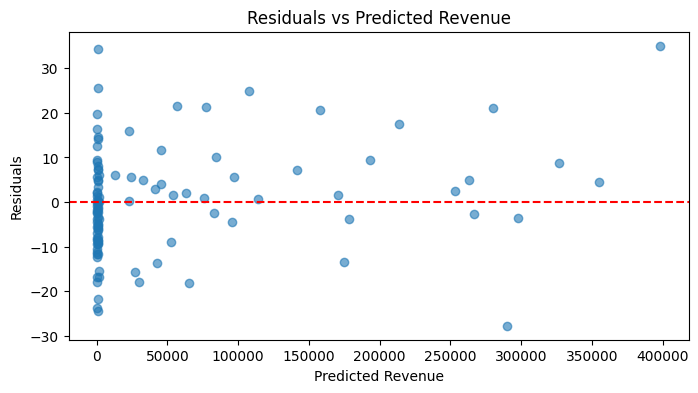

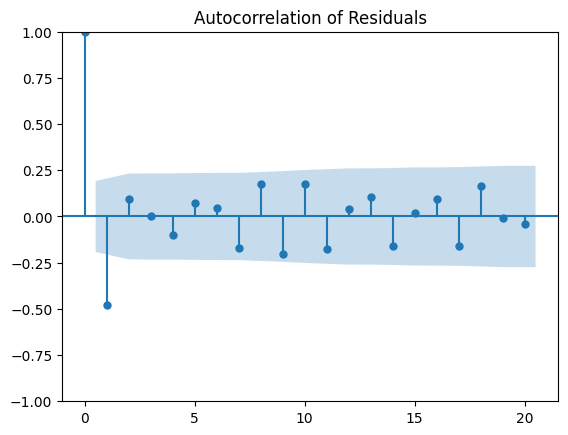

In [28]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ---- Predict revenue ----
yhat_full = xgb_model.predict(X2)  # use your trained model directly
resid = y2 - yhat_full  # residuals

# ---- Residual plot ----
plt.figure(figsize=(8,4))
plt.scatter(yhat_full, resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Revenue')
plt.show()

# ---- ACF of residuals ----
sm.graphics.tsa.plot_acf(resid, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()


                 feature         vif
0                  const  592.319606
11            promotions  284.298967
12         price_x_promo  283.645956
4     instagram_spend_ad    1.942098
10         average_price    1.921569
7                   sin1    1.705033
3        tiktok_spend_ad    1.398204
5      snapchat_spend_ad    1.395508
1             google_hat    1.390638
9                      t    1.264332
13              sms_send    1.194128
2      facebook_spend_ad    1.153918
8                   cos1    1.098698
6   followers_diff_lag_1    1.095580


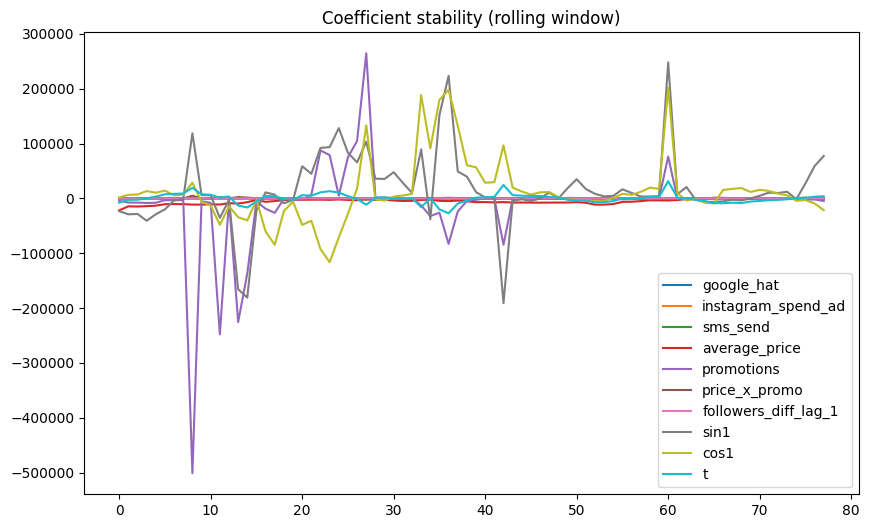

In [29]:

# VIF check
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xvif = sm.add_constant(X2)
vif = pd.DataFrame({'feature':Xvif.columns, 'vif':[variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1]) ]})
print(vif.sort_values('vif', ascending=False))

# Coefficient stability over rolling windows
coefs_over_time = []
window = 26
for start in range(0, len(df)-window):
    sub = df.iloc[start:start+window]
    # stage1 fit
    X1_sub = sub[stage1_features]; y1_sub = sub['google_spend']
    m1s = RidgeCV(alphas=[0.1,1,10], cv=3).fit(X1_sub, y1_sub)
    # stage2 fit
    sub['google_hat'] = m1s.predict(X1_sub)
    X2_sub = sub[stage2_features]; y2_sub = sub['revenue']
    try:
        m2s = ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=[0.001,0.01,0.1], cv=3).fit(X2_sub, y2_sub)
        coefs_over_time.append(m2s.coef_)
    except Exception:
        coefs_over_time.append(np.full(len(stage2_features), np.nan))

coefs_over_time = np.array(coefs_over_time)
plt.figure(figsize=(10,6))
for i, f in enumerate(stage2_features):
    plt.plot(coefs_over_time[:,i], label=f)
plt.legend(); plt.title('Coefficient stability (rolling window)')
plt.show()


In [30]:
df.columns

Index(['week', 'facebook_spend', 'google_spend', 'tiktok_spend',
       'instagram_spend', 'snapchat_spend', 'social_followers',
       'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue',
       'total_spends', 'followers_diff', 'zero_spend', 'month', 'season',
       'facebook_spend_ad', 'google_spend_ad', 'tiktok_spend_ad',
       'instagram_spend_ad', 'snapchat_spend_ad', 'instagram_lag_1',
       'followers_diff_lag_1', 'instagram_lag_2', 'followers_diff_lag_2',
       'instagram_lag_3', 'followers_diff_lag_3', 'instagram_lag_4',
       'followers_diff_lag_4', 'price_x_promo', 'insta_x_promo',
       'log1p_total_spends', 'log1p_social_followers', 'log1p_followers_diff',
       'log1p_facebook_spend', 'log1p_google_spend', 'log1p_tiktok_spend',
       'log1p_instagram_spend', 'log1p_snapchat_spend', 'sin1', 'cos1', 'sin2',
       'cos2', 'sin3', 'cos3', 't', 't2', 'google_hat', 'revenue_pred'],
      dtype='object')

In [31]:
# 9) Sensitivity simulations
# Price shocks
for shock in [-0.2, -0.1, -0.05, 0.05, 0.1, 0.2]:
    X_sim = X2.copy()
    X_sim['average_price'] = X_sim['average_price'] * (1+shock)
    preds = xgb_model.predict(X_sim)
    print('Price shock', shock, 'mean predicted revenue:', round(np.mean(preds),2))

# Promotion on/off effect
X_prom_on = X2.copy(); X_prom_on['promotions'] = 1
X_prom_off = X2.copy(); X_prom_off['promotions'] = 0
print('Pred diff promo on-off:', np.mean(xgb_model.predict(X_prom_on) - xgb_model.predict(X_prom_off)))


Price shock -0.2 mean predicted revenue: 79507.8
Price shock -0.1 mean predicted revenue: 70192.72
Price shock -0.05 mean predicted revenue: 60648.9
Price shock 0.05 mean predicted revenue: 47686.06
Price shock 0.1 mean predicted revenue: 44231.14
Price shock 0.2 mean predicted revenue: 46789.42
Pred diff promo on-off: 46.272404


In [32]:
# 10) Attribution (direct vs indirect)
# Indirect effect: a * b
a_total = model_stage1.coef_[0]  # effect of total_spends -> google
b_google = pipe_enet.named_steps['enet'].coef_[ stage2_features.index('google_hat') ]
indirect_effect = a_total * b_google
print('Indirect effect (total_spends -> google -> revenue):', indirect_effect)

# Bootstrap block-based for CI (simple implementation)
n_boot = 200
inds = np.arange(len(df))
block_size = 4
indirect_boot = []
for i in range(n_boot):
    # sample block indices
    starts = np.random.randint(0, len(df)-block_size, size=int(len(df)/block_size))
    sel = []
    for s in starts:
        sel.extend(list(range(s, s+block_size)))
    sel = np.array(sel) % len(df)
    sub = df.iloc[sel]
    # stage1
    X1b = sub[stage1_features]; y1b = sub['google_spend']
    try:
        m1b = RidgeCV(alphas=[0.1,1,10]).fit(X1b, y1b)
        sub['google_hat_b'] = m1b.predict(X1b)
        X2b = sub[stage2_features].copy(); y2b = sub['revenue']
        X2b['google_hat'] = sub['google_hat_b']
        m2b = ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=[0.001,0.01,0.1], cv=3).fit(X2b, y2b)
        a_b = m1b.coef_[0]; b_b = m2b.coef_[ stage2_features.index('google_hat') ]
        indirect_boot.append(a_b * b_b)
    except Exception:
        continue

print('Indirect CI:', np.percentile(indirect_boot, [2.5, 50, 97.5]))


Indirect effect (total_spends -> google -> revenue): 4958.556199649774
Indirect CI: [-3.2756839   1.65471578  6.52411109]


In [34]:
import os
import joblib

# 11) Save models & results
results_dir = './data/results'  # Adjust as needed
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

joblib.dump(model_stage1, os.path.join(results_dir, 'stage1_ridge.joblib'))
joblib.dump(xgb_model, os.path.join(results_dir, 'stage2_enet.joblib'))
df.to_csv(os.path.join(results_dir, 'engineered_features_predictions.csv'), index=False)

# Quick write-up snippet generator
with open(os.path.join(results_dir, 'writeup_snippet.txt'), 'w') as f:
    f.write('Stage1 model (google ~ total_spends) coefficients:\n')
    for name,coefv in zip(stage1_features, model_stage1.coef_):
        f.write(f"{name}: {coefv}\n")
    # Check if xgb_model has 'enet' step before accessing its coefficients
    if hasattr(xgb_model, 'named_steps') and 'enet' in xgb_model.named_steps:
        f.write('\nStage2 model coefficients (ElasticNet):\n')
        for name,coefv in zip(stage2_features, xgb_model.named_steps['enet'].coef_):
            f.write(f"{name}: {coefv}\n")
    else:
        # Handle the case where xgb_model is not a pipeline with 'enet'
        f.write('\nStage2 model coefficients (XGBoost):\n')
        for name, coefv in zip(X2.columns, xgb_model.feature_importances_):
             f.write(f"{name}: {coefv}\n")


print('Notebook run complete. Check results/ directory for outputs.')

Notebook run complete. Check results/ directory for outputs.
